# TP10 - Time Series Tutorial
Duarte Balata(46304) and Miguel Oliveira (55772)

### Persistence model

We start by importing all the required modules and libraries.

In [20]:
import warnings
warnings.filterwarnings('ignore')
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

%matplotlib inline

We then define the function to perform the tasks shown on the tutorial.

In [21]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime(x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an MLP network to training data
def fit_model(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 4
        train_trimmed = train_scaled[2:, :]
        model = fit_model(train_trimmed, batch_size, epochs, neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

We import the dataset, split the data into train and test sets, then we define the persistence model in order to make a forecast and establish a baseline performance for timeseries prediction.

In [22]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
 
def parser(x):
    return datetime.strptime(x, '%Y-%m')
 
series = read_csv(path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# Create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))
 
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

       t-1    t+1
0      NaN   6550
1   6550.0   8728
2   8728.0  12026
3  12026.0  14395
4  14395.0  14587
Test MSE: 13356460.486


In [24]:
print('Test RMSE: %.3f' % sqrt(test_score))

Test RMSE: 3654.649


Then a plot is created to highlight the difference between the actual time series (orange) and the predicted values (green) from the baseline model, which will be 1 step behind reality.

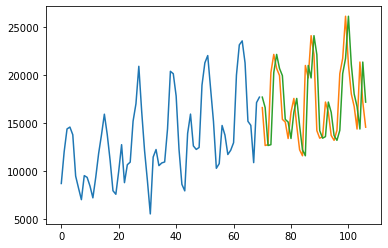

In [4]:
# plot predictions and expected results
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

This baseline model can be used as a point of reference for all other modeling techniques on the problem. If a more complex model achieves a performance below the one on the baseline model, the technique should then be tuned or abandoned.

## Focused time-lagged feedforward network (FTLFN)

We then defined the required functions to implement the Focused time-lagged feedforward network and run the model 10 times, with a single neuron on the hidden for 500 epochs.

0) TrainRMSE = 3201.327517, TestRMSE = 3684.280254
1) TrainRMSE = 3273.857564, TestRMSE = 3895.230412
2) TrainRMSE = 3273.457442, TestRMSE = 3881.282036
3) TrainRMSE = 3201.349668, TestRMSE = 3684.174579
4) TrainRMSE = 3269.975300, TestRMSE = 3899.787881
5) TrainRMSE = 3233.449382, TestRMSE = 3918.292977
6) TrainRMSE = 3229.878872, TestRMSE = 3936.226982
7) TrainRMSE = 3201.354171, TestRMSE = 3684.187840
8) TrainRMSE = 3201.332186, TestRMSE = 3684.270534
9) TrainRMSE = 3201.327617, TestRMSE = 3684.297254


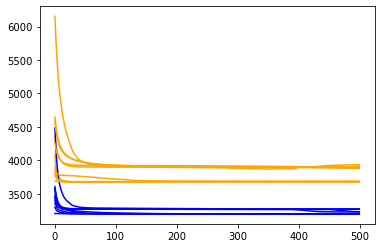

In [5]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime(x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # forecast dataset
    output = model.predict(X, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse
 
# fit an MLP network to training data
def fit(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # prepare model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history
 
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 500
    n_neurons = 1
    n_lag = 1
    # load dataset
    series = read_csv(path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE = %f, TestRMSE = %f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_epochs.png')
 
# entry point
run()

We can see that developed model already performed better than the baseline, indicating that it is making useful predictions (~3200 < 3655 RMSE). However, there are still adjustements that we can do to increase the performance.

The rapid leveling of both RMSE of the train and test curves suggest that the model could benefit from additional lags observations to the data or more neurons. We will first start by experimenting with the number of neurons.

## Vary Hidden Layer Neurons

Adding neurons will increase learning capacity at a cost of possible overfitting - we will test with adding neurons to a hidden layer with 500 epochs and evaluate the results

In [6]:
# load dataset
series = read_csv(path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 30
results = DataFrame()
lag = 1
epochs = 500
# vary neurons
neurons = [1, 2, 3, 4, 5]
for n in neurons:
    print("Neurons:", n)
    results[str(n)] = experiment(repeats, series, epochs, lag, n)

Neurons: 1
1) Test RMSE: 3784.122
2) Test RMSE: 3683.936
3) Test RMSE: 3784.122
4) Test RMSE: 3783.852
5) Test RMSE: 3784.122
6) Test RMSE: 3942.221
7) Test RMSE: 3879.020
8) Test RMSE: 3784.122
9) Test RMSE: 3784.122
10) Test RMSE: 3684.360
11) Test RMSE: 3684.218
12) Test RMSE: 3684.281
13) Test RMSE: 3684.232
14) Test RMSE: 3684.212
15) Test RMSE: 3783.893
16) Test RMSE: 3684.147
17) Test RMSE: 3942.393
18) Test RMSE: 3881.654
19) Test RMSE: 3872.744
20) Test RMSE: 3684.359
21) Test RMSE: 3684.136
22) Test RMSE: 3877.676
23) Test RMSE: 3783.889
24) Test RMSE: 3783.852
25) Test RMSE: 3909.459
26) Test RMSE: 3878.391
27) Test RMSE: 3684.240
28) Test RMSE: 3783.884
29) Test RMSE: 3684.237
30) Test RMSE: 3878.231
Neurons: 2
1) Test RMSE: 3722.399
2) Test RMSE: 3783.852
3) Test RMSE: 3878.888
4) Test RMSE: 3722.304
5) Test RMSE: 3881.156
6) Test RMSE: 3731.778
7) Test RMSE: 3891.411
8) Test RMSE: 3941.090
9) Test RMSE: 3898.148
10) Test RMSE: 3937.840
11) Test RMSE: 3682.822
12) Test RMS

                 1            2            3            4            5
count    30.000000    30.000000    30.000000    30.000000    30.000000
mean   3780.937611  3758.829867  3764.067004  3758.402738  3736.151839
std      88.690656    85.621004    90.591111    81.925795    57.673287
min    3683.935845  3650.231665  3655.725759  3663.781131  3663.500872
25%    3684.250405  3684.081512  3695.742223  3697.800779  3705.180483
50%    3783.891054  3730.369762  3735.091754  3723.114402  3720.977983
75%    3876.442912  3783.907707  3783.909012  3850.245252  3765.960766
max    3942.393460  3941.090080  3987.649869  3943.134773  3894.261180


<AxesSubplot:>

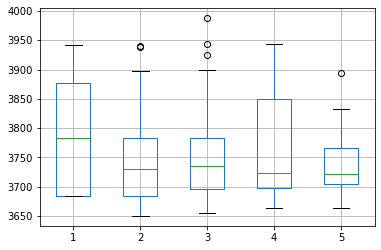

In [7]:
# summarize results
print(results.describe())
# save boxplot
results.boxplot()

Based on the output above - 5 neurons presented the best average result, therefore we will begin experimenting by adding 5 neurons to the hidden layer.

0) TrainRMSE = 3134.223789, TestRMSE = 3795.730141
1) TrainRMSE = 3158.119787, TestRMSE = 3716.337859
2) TrainRMSE = 3122.657084, TestRMSE = 3815.295523
3) TrainRMSE = 3195.273314, TestRMSE = 3714.863595
4) TrainRMSE = 3193.031682, TestRMSE = 3714.250433
5) TrainRMSE = 3147.423597, TestRMSE = 3858.827083
6) TrainRMSE = 3124.090803, TestRMSE = 3804.194621
7) TrainRMSE = 3136.601445, TestRMSE = 3790.759412
8) TrainRMSE = 3195.709369, TestRMSE = 3701.847571
9) TrainRMSE = 3193.329945, TestRMSE = 3725.536334


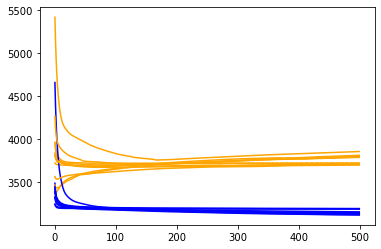

In [9]:
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 500
    n_neurons = 5
    n_lag = 1
    # load dataset
    series = read_csv(path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE = %f, TestRMSE = %f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('diagnostic_neurons.png')
 
 # entry point
run()

The plots look very similar in terms RMSE variation over the training epochs. Both lines flatten at about the same rate -also no clear signs of overfitting. However, by looking at the RMSE metrics values over the 10 repeats, we can see that the values improved comparatively to the first model with 1 neuron in the hidden layer.

We then proceed to experiment with increasing the lag. 

## Vary Hidden Layer Neurons with Lag

Please note that, increased the lag of the observations will increase the scale of the number of input neurons in the model accordingly (e.g. 3 lag observations as input will result in 3 input neurons). 

This, in turn, effects the total number of training patterns during the process of conversion of the time series data to a supervised learning problem. As per the tutorial, to mitigate this, the batch size was reduced from 4 to 2. We will maitain the experiments with 500 epochs.

In [10]:
# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 2
        model = fit_model(train_scaled, batch_size, epochs, neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# load dataset
series = read_csv(path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 30
results = DataFrame()
epochs = 500
# vary neurons
neurons = [1, 3, 5, 7]

for n in neurons:
    print("Neurons:", n)
    results[str(n)] = experiment(repeats, series, epochs, n, n)
    
# summarize results
print(results.describe())

Neurons: 1
1) Test RMSE: 3876.727
2) Test RMSE: 3684.206
3) Test RMSE: 3783.805
4) Test RMSE: 3683.985
5) Test RMSE: 3784.060
6) Test RMSE: 3875.139
7) Test RMSE: 3784.060
8) Test RMSE: 3956.188
9) Test RMSE: 3684.221
10) Test RMSE: 3956.687
11) Test RMSE: 3783.808
12) Test RMSE: 3783.805
13) Test RMSE: 3956.710
14) Test RMSE: 3873.902
15) Test RMSE: 3956.345
16) Test RMSE: 3783.805
17) Test RMSE: 3877.091
18) Test RMSE: 3783.805
19) Test RMSE: 3784.060
20) Test RMSE: 3784.060
21) Test RMSE: 3878.390
22) Test RMSE: 3683.938
23) Test RMSE: 3683.660
24) Test RMSE: 3684.060
25) Test RMSE: 3878.087
26) Test RMSE: 3683.960
27) Test RMSE: 3783.805
28) Test RMSE: 3783.805
29) Test RMSE: 3955.702
30) Test RMSE: 3783.805
Neurons: 3
1) Test RMSE: 3677.369
2) Test RMSE: 3553.459
3) Test RMSE: 4309.502
4) Test RMSE: 3390.996
5) Test RMSE: 3452.917
6) Test RMSE: 3691.226
7) Test RMSE: 3278.941
8) Test RMSE: 3617.158
9) Test RMSE: 3818.007
10) Test RMSE: 3601.562
11) Test RMSE: 3554.573
12) Test RMS

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

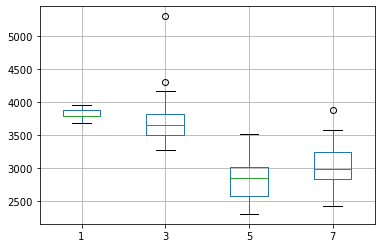

In [11]:
results.boxplot()

By changing the lag value and experimenting with different amount of neurons (in steps of 2), we were able to observe that a model with a lag and number of neurons in the hidden layer of 5 present the best results.

The overall quality of the model predictions is now better, with RMSE values bellow 3000 for the first time.

Given that, we will perform 10 diagnostic runs with our new chosen model and compare its metrics over time and performance to the ones seen previously.

In [12]:
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 2
    n_epochs = 500
    n_neurons = 5
    n_lag = 5
    # load dataset
    series = read_csv(path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE = %f, TestRMSE = %f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))

0) TrainRMSE = 2064.240417, TestRMSE = 2120.277746
1) TrainRMSE = 2142.112038, TestRMSE = 2956.463828
2) TrainRMSE = 1882.935929, TestRMSE = 2287.801241
3) TrainRMSE = 2159.106482, TestRMSE = 3270.032799
4) TrainRMSE = 1863.331484, TestRMSE = 3308.289710
5) TrainRMSE = 2061.603665, TestRMSE = 2895.163850
6) TrainRMSE = 2137.962502, TestRMSE = 2809.984269
7) TrainRMSE = 1794.236862, TestRMSE = 2298.174240
8) TrainRMSE = 2012.482905, TestRMSE = 2283.791613
9) TrainRMSE = 1949.032204, TestRMSE = 2268.214376


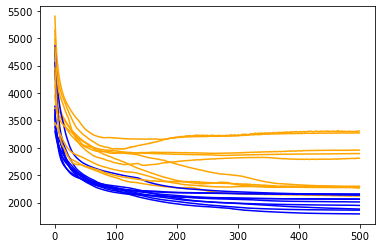

In [14]:
run()

By looking at the output metrics, we can see that we were able to achieve considerably lower RMSE values. Even though the model needs more epochs to reach its best potential.

## Persistence model with a moving average of 3

We will now use a moving average window of 3 as feature engineering for the Persistance Model previously used in the exercise. 

In [15]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv(path, header=0, index_col=0)
df = DataFrame(series.values)
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't-1', 't+1']
print(dataframe.head(10))

           mean      t-1    t+1
0           NaN      NaN   6550
1           NaN   6550.0   8728
2           NaN   8728.0  12026
3           NaN  12026.0  14395
4   9101.333333  14395.0  14587
5  11716.333333  14587.0  13791
6  13669.333333  13791.0   9498
7  14257.666667   9498.0   8251
8  12625.333333   8251.0   7049
9  10513.333333   7049.0   9545


In [16]:
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
series = read_csv(path, header=0, index_col=0)
# prepare situation
X = series.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=9101.333333, expected=14395.000000
predicted=11716.333333, expected=14587.000000
predicted=13669.333333, expected=13791.000000
predicted=14257.666667, expected=9498.000000
predicted=12625.333333, expected=8251.000000
predicted=10513.333333, expected=7049.000000
predicted=8266.000000, expected=9545.000000
predicted=8281.666667, expected=9364.000000
predicted=8652.666667, expected=8456.000000
predicted=9121.666667, expected=7237.000000
predicted=8352.333333, expected=9374.000000
predicted=8355.666667, expected=11837.000000
predicted=9482.666667, expected=13784.000000
predicted=11665.000000, expected=15926.000000
predicted=13849.000000, expected=13821.000000
predicted=14510.333333, expected=11143.000000
predicted=13630.000000, expected=7975.000000
predicted=10979.666667, expected=7610.000000
predicted=8909.333333, expected=10015.000000
predicted=8533.333333, expected=12759.000000
predicted=10128.000000, expected=8816.000000
predicted=10530.000000, expected=10677.000000
predicted

In [19]:
print('Test RMSE: %.3f' % sqrt(error))

Test RMSE: 4394.620


It is possible to see that the performance decreases, in comparison to the first baseline model, when using a moving average of 3 times points to make the predictions.

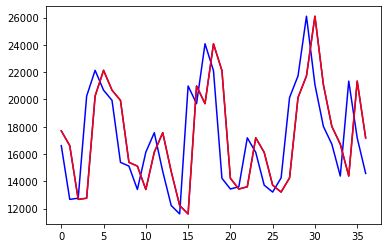

In [27]:
# plot
pyplot.plot(test, color='blue')
pyplot.plot(predictions, color='red')
pyplot.show()

## Conclusion

By comparing our results with the ones on the previous exercise we can see that the performance on the optized FTLFN is slightly better better than the one achieved using a RNN(LSTM), since were able to obtain RMSE values averaging ~2000 on the optimal model, which is lower than the ~2500 achieved with the RNN using a 12 month window. Despite that, as expected the RNN still performed considerably better than the baseline models.

Even though this was the case for this specific exercise and model tuning efforts, it can't be taken as general rule, as both types of models are valuable and have been proven efficient in predicting values from time series data on multiple occasions.